# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme tensorflow opencv-pythonu matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Aryan\AppData\Local\Temp\pip-install-kqeeletv\tensorflow-gpu_f995f6d1cc5542bfa169a8df601b4b83\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build wheels for tensorflow-gpu, which is required to install pyproject.toml-

### 1.2 Collect Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [296]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    time.sleep(0.5)
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [297]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [298]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [299]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [300]:
tf.config.list_physical_devices('GPU')

[]

In [301]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

[]


### 2.3 Load Image into TF Data Pipeline

In [302]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [303]:
images.as_numpy_iterator().next()

b'data\\images\\2cc29d2f-e81a-11ed-a1aa-ef72e293c2ce.jpg'

In [304]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [305]:
images = images.map(load_image)

In [306]:
images.as_numpy_iterator().next()

array([[[249, 233, 199],
        [255, 241, 207],
        [253, 239, 204],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[252, 233, 200],
        [252, 236, 202],
        [251, 235, 201],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[254, 234, 201],
        [251, 231, 198],
        [254, 235, 202],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[251, 217, 169],
        [251, 217, 169],
        [255, 224, 176],
        ...,
        [ 29,  30,  25],
        [ 30,  29,  27],
        [ 30,  29,  27]],

       [[255, 223, 174],
        [255, 223, 174],
        [255, 227, 179],
        ...,
        [ 29,  29,  27],
        [ 30,  28,  29],
        [ 30,  28,  29]],

       [[252, 222, 172],
        [254, 224, 174],
        [255, 226, 178],
        ...,
        [ 29,  29,  27],
        [ 30,  28,  29],
        [ 30,  28,  29]]

In [307]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [308]:
image_generator = images.batch(4).as_numpy_iterator()

In [309]:
plot_images = image_generator.next()

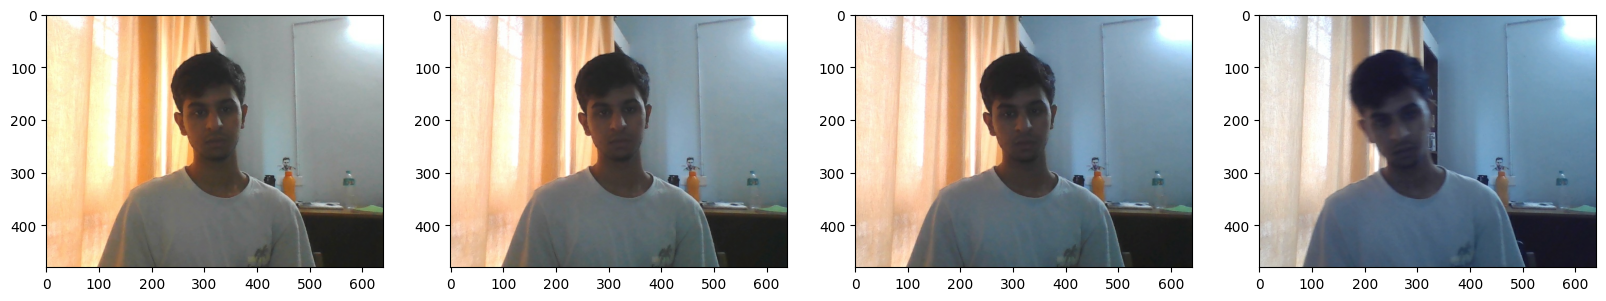

In [310]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [311]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [312]:
import albumentations as alb

In [313]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [351]:
img = cv2.imread(os.path.join('data','train', 'images','2d182bcf-e81a-11ed-9527-ef72e293c2ce.jpg'))

In [352]:
img

array([[[211, 229, 252],
        [206, 226, 251],
        [206, 225, 252],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[211, 229, 252],
        [208, 228, 253],
        [207, 226, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[211, 228, 254],
        [207, 227, 252],
        [206, 225, 252],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[180, 213, 252],
        [174, 207, 246],
        [181, 212, 251],
        ...,
        [ 28,  29,  25],
        [ 28,  29,  25],
        [ 29,  30,  26]],

       [[182, 215, 254],
        [182, 215, 254],
        [187, 219, 255],
        ...,
        [ 28,  29,  25],
        [ 28,  29,  25],
        [ 28,  29,  25]],

       [[179, 212, 251],
        [183, 216, 255],
        [186, 218, 254],
        ...,
        [ 28,  29,  25],
        [ 28,  29,  25],
        [ 28,  29,  25]]

In [353]:
with open(os.path.join('data', 'train', 'labels', '2d182bcf-e81a-11ed-9527-ef72e293c2ce.json'), 'r') as f:
    label = json.load(f)

In [354]:
label

{'version': '5.2.0.post4',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[238.71794871794873, 105.12820512820514],
    [378.71794871794873, 277.43589743589746]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\2d182bcf-e81a-11ed-9527-ef72e293c2ce.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNO

In [355]:
label['shapes'][0]['points']

[[238.71794871794873, 105.12820512820514],
 [378.71794871794873, 277.43589743589746]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [356]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [357]:
coords

[238.71794871794873,
 105.12820512820514,
 378.71794871794873,
 277.43589743589746]

In [358]:
coords = list(np.divide(coords, [640,480,640,480]))

In [359]:
coords

[0.3729967948717949,
 0.21901709401709404,
 0.5917467948717949,
 0.577991452991453]

### 4.4 Apply Augmentations and View Results

In [360]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [361]:
augmented['bboxes'][0][2:]

(0.4393732193732194, 0.8263817663817663)

In [362]:
augmented['bboxes']

[(0.1282621082621083,
  0.4434757834757834,
  0.4393732193732194,
  0.8263817663817663)]

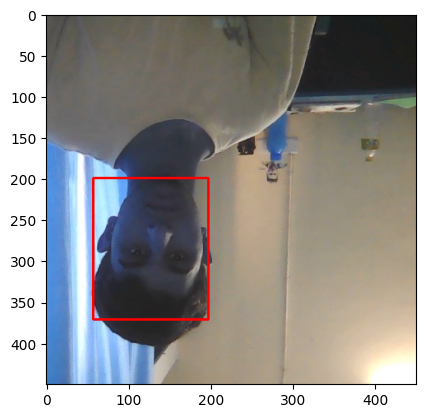

In [363]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [364]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [365]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [366]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [367]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [368]:
train_images.as_numpy_iterator().next()

array([[[0.6428309 , 0.65392154, 0.6661152 ],
        [0.6173407 , 0.63302696, 0.63596815],
        [0.61648285, 0.6321691 , 0.62824756],
        ...,
        [0.9965686 , 0.9965686 , 0.9936274 ],
        [0.9995098 , 0.9995098 , 0.9916667 ],
        [0.98970586, 0.99846816, 0.98180145]],

       [[0.65588236, 0.672549  , 0.67561275],
        [0.652451  , 0.67745095, 0.6691176 ],
        [0.6489583 , 0.67395836, 0.665625  ],
        ...,
        [0.9965686 , 0.9952206 , 0.96231616],
        [0.99080884, 0.97414213, 0.93737745],
        [0.99938726, 0.9877451 , 0.9356005 ]],

       [[0.6598039 , 0.6877451 , 0.6784314 ],
        [0.63829654, 0.6745711 , 0.6623162 ],
        [0.6397059 , 0.68284315, 0.6671569 ],
        ...,
        [0.9721201 , 0.9490809 , 0.8573529 ],
        [0.9952819 , 0.9574755 , 0.8613971 ],
        [0.98860294, 0.95281863, 0.8436887 ]],

       ...,

       [[0.38186276, 0.40539217, 0.40110293],
        [0.34552696, 0.38039216, 0.36764705],
        [0.3324142 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [369]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [370]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [371]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [372]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [373]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2693, 0.172 , 0.5933, 0.571 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [374]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [375]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [376]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [377]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [378]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.2339 , 0.1084 , 0.5815 , 0.5757 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.2142 , 0.2177 , 0.662  ],
        [0.735  , 0.386  , 1.     , 0.782  ],
        [0.     , 0.2798 , 0.1636 , 0.8027 ],
        [0.577  , 0.4084 , 0.883  , 0.8335 ],
        [0.04443, 0.1831 , 0.3887 , 0.624  ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

### 7.3 View Images and Annotations

In [379]:
data_samples = train.as_numpy_iterator()

In [380]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


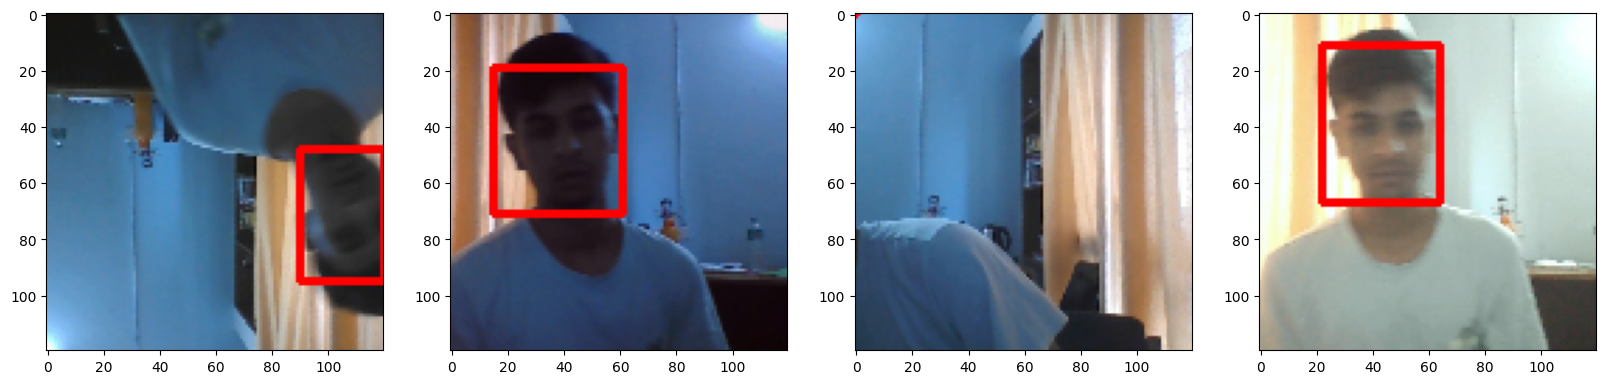

In [381]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [382]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [84]:
vgg = VGG16(include_top=False)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
58889256/58889256 [==============================] - 31s 1us/step


In [383]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [384]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [385]:
facetracker = build_model()

In [386]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_7[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [387]:
X, y = train.as_numpy_iterator().next()

In [388]:
X.shape

(8, 120, 120, 3)

In [389]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 499ms/step


In [390]:
classes, coords

(array([[0.29199442],
        [0.2912803 ],
        [0.44592625],
        [0.32667002],
        [0.413745  ],
        [0.466799  ],
        [0.53334737],
        [0.35791668]], dtype=float32),
 array([[0.6515897 , 0.59753674, 0.3350515 , 0.5252062 ],
        [0.68018425, 0.6146335 , 0.2967673 , 0.57288   ],
        [0.66203845, 0.6285306 , 0.43639192, 0.62178004],
        [0.72046626, 0.5701484 , 0.36042672, 0.68305576],
        [0.585697  , 0.5261992 , 0.38204315, 0.567724  ],
        [0.6336824 , 0.49487448, 0.4806456 , 0.61482996],
        [0.6165035 , 0.5987226 , 0.44046935, 0.59569114],
        [0.68654716, 0.6019122 , 0.36356315, 0.6095837 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [391]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [392]:
lr_decay

0.0007047216349541929

In [393]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [394]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [395]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [396]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.1747484>

In [397]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.93434227>

In [398]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.1747484>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [399]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [400]:
model = FaceTracker(facetracker)

In [401]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [402]:
logdir='logs'

In [403]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [404]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 1467s 3s/step - total_loss: 0.4149 - class_loss: 0.1252 - regress_loss: 0.3523 - val_total_loss: 0.1916 - val_class_loss: 0.1408 - val_regress_loss: 0.1212
Epoch 2/10
473/473 [==============================] - 874s 2s/step - total_loss: 0.1607 - class_loss: 0.0548 - regress_loss: 0.1334 - val_total_loss: 0.0313 - val_class_loss: 1.5080e-05 - val_regress_loss: 0.0313
Epoch 3/10
473/473 [==============================] - 929s 2s/step - total_loss: 0.1405 - class_loss: 0.0499 - regress_loss: 0.1155 - val_total_loss: 0.0251 - val_class_loss: 0.0025 - val_regress_loss: 0.0238
Epoch 4/10
473/473 [==============================] - 913s 2s/step - total_loss: 0.1067 - class_loss: 0.0377 - regress_loss: 0.0878 - val_total_loss: 0.0176 - val_class_loss: 3.3677e-05 - val_regress_loss: 0.0176
Epoch 5/10
473/473 [==============================] - 901s 2s/step - total_loss: 0.1135 - class_loss: 0.0350 - regress_loss: 0.0960 - val_total_loss: 0.020

### 10.3 Plot Performance

In [405]:
hist.history

{'total_loss': [0.8290900588035583,
  0.7007794380187988,
  0.0486646369099617,
  0.05494386702775955,
  0.008904152549803257,
  0.004166693892329931,
  0.019831914454698563,
  0.025518815964460373,
  0.004117668140679598,
  0.006082307081669569],
 'class_loss': [0.3530961573123932,
  0.26248833537101746,
  0.031833067536354065,
  0.0021605202928185463,
  0.0007949230493977666,
  0.0013899448094889522,
  0.001808161148801446,
  5.960465188081798e-08,
  0.0001677082182141021,
  0.00024407051387242973],
 'regress_loss': [0.652541995048523,
  0.5695352554321289,
  0.03274810314178467,
  0.053863607347011566,
  0.008506691083312035,
  0.003471721662208438,
  0.018927833065390587,
  0.025518786162137985,
  0.004033814184367657,
  0.005960271693766117],
 'val_total_loss': [0.19163987040519714,
  0.03132987022399902,
  0.025066152215003967,
  0.01764942891895771,
  0.020252414047718048,
  0.9833551049232483,
  0.024293171241879463,
  0.07565228641033173,
  0.019161464646458626,
  0.0056218625

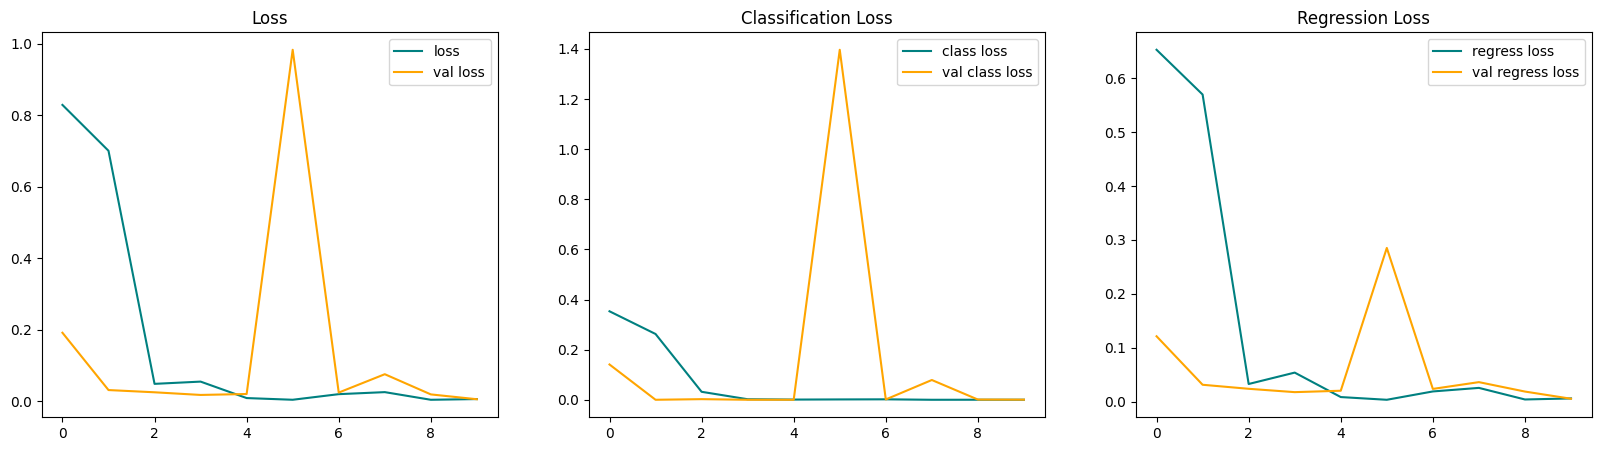

In [406]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [407]:
test_data = test.as_numpy_iterator()

In [408]:
test_sample = test_data.next()

In [409]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 547ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


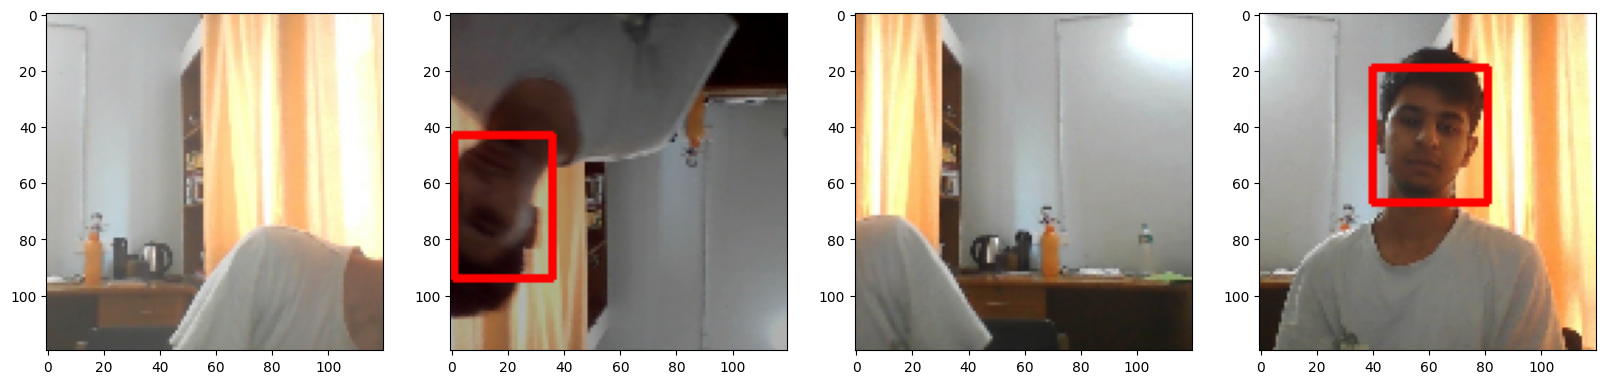

In [410]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [227]:
from tensorflow.keras.models import load_model

In [228]:
facetracker.save('facetracker.h5')

In [229]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [415]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 95ms/step
